This notebook accompanies the paper titled, "Identifying Nanoscale Structure−Function Relationships UsingMultimodal Atomic Force Microscopy, Dimensionality Reduction, and Regression Techniques" by Jessica Kong, Rajiv Giridharagopal, Jeffrey S. Harrison, and David S. Ginger.

This notebook was written in Python 3.5; aside from the typical Python computing packages (scipy, numpy, skl, dipy is required. 

In [1]:
import numpy as np
import os
import zipfile
import sys
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('./../io')
sys.path.append('./../data')
#for reading in raw image files
from util import HyperImage, load_ibw, hyperslice, to_2d
#for image processing
#image registration
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (AffineTransform2D,
                                   RigidTransform2D,
                                   RotationTransform2D,
                                  ScalingTransform2D, 
                                   TranslationTransform2D)
from scipy import signal
from scipy.ndimage import rotate
#for standardizing data matrix
from sklearn.preprocessing import scale
#for PCA
from sklearn.decomposition import PCA as sklearnPCA
#for randomly splitting data into training and test sets
from sklearn.model_selection import train_test_split
#linear regression package
from sklearn import linear_model 
#for hyperspectral decomposition
from sklearn.decomposition import FastICA, NMF
from pysptools.eea import ATGP, NFINDR, PPI
#for calculating p value
from scipy.stats import f

C:\Users\kongjy\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import Images and laser profile

In [2]:
hyperfiles=zipfile.ZipFile('./../data/hyperspectral_pifm.zip')
hyperfiles.extractall(path='.')

In [3]:
#import hyperspectral image 
hyperimage=HyperImage('./hyperspectral_pifm/Film19_0016.txt')
hyper=hyperimage.hyper_image
hypertopo=hyperimage.channel_data[:,:,0]
#flatten
hypertopo=signal.detrend(hypertopo, axis=1, type="linear")
#get wavenumber range from hyper file 
exp_wavenumber=hyperimage.wavelength_data
#sum intensities within range of spectrum at each pixel
hyperint=signal.detrend(hyperslice(hyperimage, start=760, stop=1875), axis=1, type="linear")
#import corresponding cAFM image
cAFMimage=load_ibw('./../data/Film19_0010.ibw')
cAFMtopo=cAFMimage[:,:,0]
#flatten
cAFMtopo=signal.detrend(cAFMtopo, axis=1, type="linear")
#current channel 
cAFM=cAFMimage[:,:,3]
#store cAFM values in list. 
cAFMlist=cAFM.reshape((65536,))

#PiFM laser profile
laserprofile=np.loadtxt('./../data/laserprofile.txt', delimiter = '\t', skiprows=1 )
laser_wavenumber=laserprofile[:,0]
laser_power=laserprofile[:,1]

#interpolated laser power 
laserpower_interp= np.interp(exp_wavenumber, laser_wavenumber, laser_power)

In [4]:
#Fig1
#flattened=load_ibw('ct0_hpt1_hpi2.ibw')
#cafmtopo=np.rot90(flattened[:,:,7], k=3)
#show(cafmtopo[25:,2:249])
#plt.savefig('currenttopo.svg',format='svg', dpi=800)
#hypertopo=np.rot90(flattened[:,:,8], k=3)
#fig=show(hypertopo[25:,2:249])
#plt.savefig('hypertopo.svg', format='svg', dpi=800)
#hyperint=np.rot90(flattened[:,:,9], k=3)
#show(hyperint[25:,2:249])
#plt.savefig('hyperint.svg', format='svg', dpi=800)

### Function to show images

In [5]:
def show(img, cmap = 'plasma', colorbar = True):
    """Displays image with colorbar."""
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if colorbar == True:
        plt.colorbar()
    return 

## 1. Image Registration 

In [6]:
static=hypertopo
moving=cAFMtopo

In [7]:
#set up parameters for affine transformation (see SI for details):
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


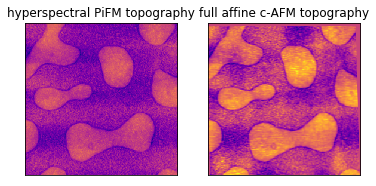

In [8]:
#optimize transformation in x-,y-space:
transform = TranslationTransform2D()
params0 = None
static = hypertopo
moving = cAFMtopo
cAFMrotated=cAFM
translation = affreg.optimize(static, moving, transform, params0, starting_affine=None)
transformed = translation.transform(moving)
#apply transformation to current image:
cAFM_transformed = translation.transform(cAFMrotated)

#use prior x-,y-transformation as starting point and optimize with respect to rotation: 
starting_affine = translation.affine
transform = RigidTransform2D() 
rigid = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply transformation to c-AFM topography: 
transformed = rigid.transform(moving)
#apply transformation to current image: 
cAFM_transformed = rigid.transform(cAFMrotated)

#use prior rigid transformation as starting point and optimize with respect to a full affine transformation: 
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply to c-AFM topography
transformed = affine.transform(moving)
#apply to current image: 
cAFM_transformed = affine.transform(cAFMrotated)

colormap='plasma'
fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(static, cmap=colormap)
ax1.set_title('hyperspectral PiFM topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2 = ax2.imshow(transformed, cmap=colormap)
ax2.set_title('full affine c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

## 2. Principal Component Analysis (PCA) 

In [9]:
#convert cropped hyperspectral matrix of dimension (XxYx559) into power-corrected (XxY)x559 matrix. 
spectralfeat = to_2d(hyper[25:,2:249,:], laserpower_interp[:])

In [10]:
mean=np.mean(spectralfeat, axis=0)
std=np.std(spectralfeat, axis=0)

In [11]:
#laser corrected hyperspectral image
hyper_corr=spectralfeat.reshape(231,247,559)

In [12]:
spectralfeat_std = scale(spectralfeat, axis=0)
PCA = sklearnPCA()
PCA.fit(spectralfeat_std[:,1:550])
#PCA.fit(spectralfeat[:,1:550])
components = PCA.components_
scores = PCA.transform(spectralfeat_std[:,1:550])
#scores = PCA.transform(spectralfeat[:,1:550])
scores_maps = scores.reshape((231,247,549))

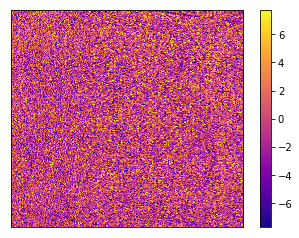

In [13]:
fig=show(scores_maps[:,:,2])
#plt.savefig('score2map.svg', format='svg', dpi=350)

In [14]:
#plt.plot(exp_wavenumber[1:],components[1], linewidth=3, color='darkblue')
#plt.gca().invert_xaxis()
#plt.savefig('PC2.svg', format='svg', dpi=400)
#plt.plot(exp_wavenumber[1:],components[2], linewidth=3, color='darkblue')
#plt.gca().invert_xaxis()
#fig=show(scores_maps[:,:,0])
#plt.savefig('score1map.svg', format='svg', dpi=800)
#show(scores_maps[:,:,1])
#plt.savefig('score2map.svg', format='svg', dpi=800)

In [15]:
#np.savetxt('pc1.txt', components[0])
#np.savetxt('pc2.txt', components[1])
#np.savetxt('wavenumberpc.txt', exp_wavenumber[1:550])

## 3. Multiple Linear Regression (MLR)

In [16]:
#split data into testing and training sets. 
cAFMshiftlist = cAFM_transformed[25:,2:249].reshape((57057,1))
PC=10
train_x, test_x, train_y, test_y = train_test_split(scores[:,0:PC],cAFMshiftlist,test_size=0.90, train_size=0.10, random_state=4)
#fit linear regression model with training data set 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,1,'Predicted Current')

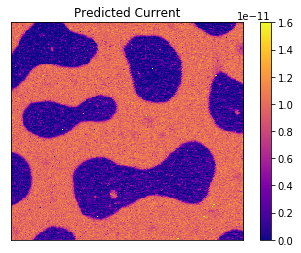

In [17]:
#construct cAFM image using linear regression model and display
cAFMpred = regr.predict(scores[:,0:PC])
cAFMpredimage = cAFMpred.reshape(231,247)
error = cAFMpredimage-cAFM_transformed[25:,2:249]
fig = show(cAFMpredimage, cmap='plasma')
plt.clim(0,1.6e-11)
plt.title('Predicted Current')

Text(0.5,1,'Error')

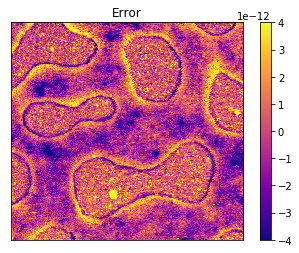

In [18]:
fig = show(error, cmap='plasma')
plt.clim(-4e-12,4e-12)
plt.title('Error')
#plt.savefig('error.svg', format='svg', dpi=800)

## 4. Error Metrics

Text(0,0.5,'Counts')

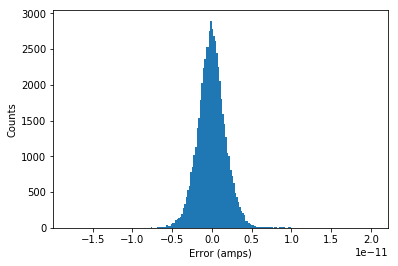

In [19]:
#histogram of error 
error_list=error.reshape((57057,1))
error_mean=error_list.mean()
n, bins, patches=plt.hist(error_list, bins=200, histtype='stepfilled')
plt.xlabel('Error (amps)')
plt.ylabel('Counts')

In [20]:
#calculate error metrics  with testing portion of data set 
x = test_y
y = regr.predict(test_x)
test_size=int(x.shape[0])
error_test = []
#real - predicted 
for i in range(len(x)):
    error_test.append(x[i] - y[i])
RSS_test = sum(np.square(error_test))
TSS_test = sum((x - x.mean())**2)
Rsquared_test = 1- (RSS_test/TSS_test)
RSE_test = np.sqrt(RSS_test/(test_size-2))
print(Rsquared_test, RSE_test)

[0.85786145] [1.77930242e-12]


In [21]:
#F-statistic 
predictors = 2
Fnumerator = (TSS_test-RSS_test)/predictors
Fdenominator = RSS_test/(test_size-predictors-1)
dfn = predictors
dfd = test_size-predictors-1
F= Fnumerator/Fdenominator
pval = 1 - f.cdf(F, dfn, dfd)
print(F, pval)

[154955.59603646] [1.11022302e-16]


## 5. Error Analysis

In [22]:
reconstruct = (np.dot(scores[:,:PC], components[:PC,:]))
reconstruct_avg=np.average(reconstruct, axis=0)
hyper_reconstruct = reconstruct.reshape((231,247,549))

In [23]:
error_list = error.reshape((57057,1))
std_err=error_list.std()

In [24]:
masked_error=np.zeros((231,247))
thresh_error= 3*std_err
for x in range(int(error.shape[0])):
    for y in range(int((error.shape[1]))):
        if error[x,y] > thresh_error:
            masked_error[x,y]=1
        else:
            masked_error[x,y]=0
            
no_p3ht_spectra=np.count_nonzero(masked_error)
p3ht_spectra=np.zeros((no_p3ht_spectra, 549))
counter=0
for x in range(int(error.shape[0])):
    for y in range(int((error.shape[1]))):
        if error[x,y] > thresh_error:
            #p3ht_spectra[counter]=hyper[x+25,y]
            p3ht_spectra[counter]=hyper_reconstruct[x,y]
            counter+=1
avg_p3ht=np.average(p3ht_spectra, axis=0)

Text(0.5,1,'Pixels with Error > (3*std) pA')

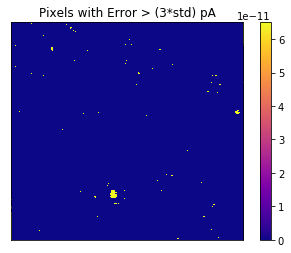

In [25]:
fig=plt.imshow(masked_error, cmap='plasma')
plt.colorbar()
plt.clim(0e-11,6.5e-11)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Pixels with Error > (3*std) pA')
#plt.savefig('masked_error.svg', format='svg', dpi=800)

In [26]:
pmma_reg=np.zeros((231,247))
thresh_cond=2.0e-12
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] < thresh_cond:
            pmma_reg[x,y]=1
        else:
            pmma_reg[x,y]=0
no_pmma_spectra=np.count_nonzero(pmma_reg)
pmma_spectra=np.zeros((no_pmma_spectra, 549))
counter=0
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] < thresh_cond:
            #pmma_spectra[counter]=hyper[x+25,y]
                        #reconstruction
            pmma_spectra[counter]=hyper_reconstruct[x,y]
            counter+=1
avg_pmma=np.average(pmma_spectra, axis=0)

Text(0.5,1,'PMMA mask, predicted current < 2pA')

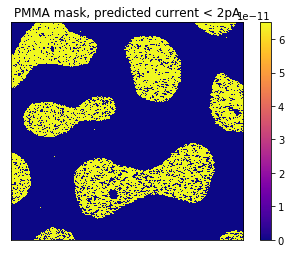

In [27]:
fig=plt.imshow(pmma_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,6.5e-11)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('PMMA mask, predicted current < 2pA')
#plt.savefig('pmma_mask.svg', format='svg', dpi=800)

In [28]:
#p3ht reg
p3htmatrix_reg=np.zeros((231,247))
thresh_cond=10e-12
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] > thresh_cond:
            p3htmatrix_reg[x,y]=1
        else:
            p3htmatrix_reg[x,y]=p3htmatrix_reg[x,y]
no_p3htmatrix_spectra=np.count_nonzero(p3htmatrix_reg)
p3htmatrix_spectra=np.zeros((no_p3htmatrix_spectra, 549))
counter=0
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] > thresh_cond:
            #p3htmatrix_spectra[counter]=hyper[x+25,y]
                        #reconstruction
            p3htmatrix_spectra[counter]=hyper_reconstruct[x,y]
            counter+=1
avg_p3htmatrix=np.average(p3htmatrix_spectra, axis=0)

Text(0.5,1,'P3HT mask, predicted current > 10pA')

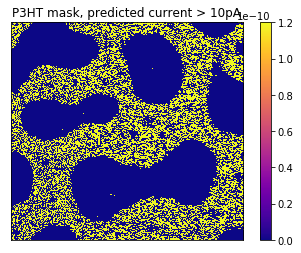

In [29]:
fig=plt.imshow(p3htmatrix_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,1.2e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('P3HT mask, predicted current > 10pA')
#plt.savefig('p3htmatrix_mask.svg', format='svg', dpi=800)

Text(0,0.5,'Intensity (a.u.)')

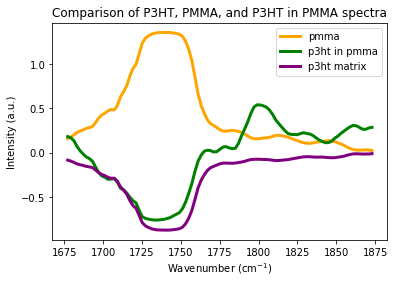

In [30]:
#plot spectra across the 3 different regions: pmma aggregates, p3ht matrix, and p3ht in pmma
%matplotlib inline
start=1
stop=100
plt.plot(exp_wavenumber[start:stop],avg_pmma[start:stop], color="orange", linewidth=3, label="pmma")
plt.plot(exp_wavenumber[start:stop],avg_p3ht[start:stop], color="green", linewidth=3, label="p3ht in pmma")
plt.plot(exp_wavenumber[start:stop], avg_p3htmatrix[start:stop], color="purple", linewidth=3, label="p3ht matrix")
plt.legend()
plt.title('Comparison of P3HT, PMMA, and P3HT in PMMA spectra')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

Text(0,0.5,'Intensity (a.u.)')

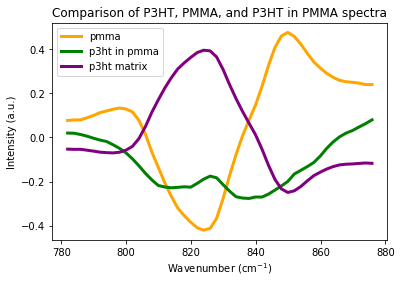

In [31]:
#plot spectra across the 3 different regions: pmma aggregates, p3ht matrix, and p3ht in pmma
%matplotlib inline
start=500
stop=548
plt.plot(exp_wavenumber[start:stop],avg_pmma[start:stop], color="orange", linewidth=3, label="pmma")
plt.plot(exp_wavenumber[start:stop],avg_p3ht[start:stop], color="green", linewidth=3, label="p3ht in pmma")
plt.plot(exp_wavenumber[start:stop], avg_p3htmatrix[start:stop], color="purple", linewidth=3, label="p3ht matrix")
plt.legend()
plt.title('Comparison of P3HT, PMMA, and P3HT in PMMA spectra')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

In [32]:
#start=0
#stop=550
#np.savetxt('PMMA.txt',avg_pmma[start:stop])
#np.savetxt('P3HTmatrix.txt',avg_p3htmatrix[start:stop])
#np.savetxt('P3HTinPMMA.txt', avg_p3ht[start:stop])
#np.savetxt('Wavenumber.txt', exp_wavenumber[start:stop])

## Hyperspectral Unmixing

#### ICA

Text(0,0.5,'Intensity (a.u.)')

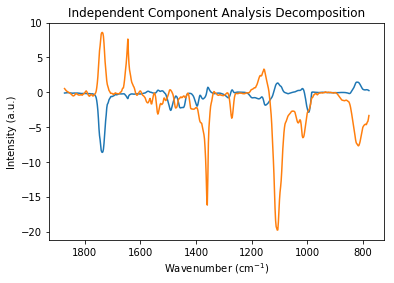

In [33]:
ica_model = FastICA(n_components=2)
ica=ica_model.fit_transform(spectralfeat[:,1:550])
ICA_comp=ica_model.components_ 
plt.plot(exp_wavenumber[1:550],ICA_comp[0,:])
plt.plot(exp_wavenumber[1:550],ICA_comp[1,:])
plt.gca().invert_xaxis()
plt.title('Independent Component Analysis Decomposition')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

In [34]:
#np.savetxt('ICAcomp1.txt',ICA_comp[0,:])
#np.savetxt('ICAcomp2.txt',ICA_comp[1,:])
#np.savetxt('WavenumberHyperspectUnmix.txt', exp_wavenumber[1:550])

#### NMF

Text(0,0.5,'Intensity (a.u.)')

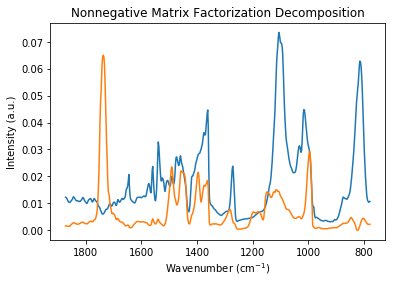

In [35]:
NMF_model=NMF(n_components=2)
NMF_fit=NMF_model.fit_transform(spectralfeat[:,1:550])
NMF_comp=NMF_model.components_
plt.plot(exp_wavenumber[1:550], NMF_comp[0,:])
plt.plot(exp_wavenumber[1:550], NMF_comp[1,:])
plt.gca().invert_xaxis()
plt.title('Nonnegative Matrix Factorization Decomposition')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

In [36]:
#np.savetxt('NMFcomp1.txt',ICA_comp[0,:])
#np.savetxt('NMFcomp2.txt',ICA_comp[1,:])

#### ATGP

Text(0.5,1,'Automatic Target Generation Process')

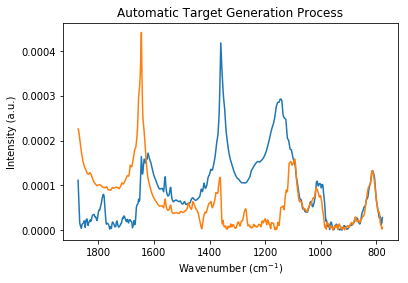

In [37]:
atgp=ATGP()
atgp_endmembers=atgp.extract(hyper_corr[:,:,1:550], q=2)
plt.plot(exp_wavenumber[1:550], atgp_endmembers[0,:])
plt.plot(exp_wavenumber[1:550], atgp_endmembers[1,:])
plt.gca().invert_xaxis()
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('Automatic Target Generation Process')

In [38]:
#np.savetxt('ATGPcomp1.txt', atgp_endmembers[0])
#np.savetxt('ATGPcomp2.txt', atgp_endmembers[1])

#### NFINDR 

In [39]:
nfindr=NFINDR()
nfindr_endmembers=nfindr.extract(hyper_corr[:,:,1:550],q=2)

Text(0.5,1,'N-FINDR')

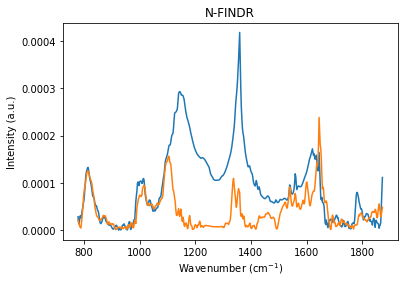

In [40]:
plt.plot(exp_wavenumber[1:550], nfindr_endmembers[0,:])
plt.plot(exp_wavenumber[1:550], nfindr_endmembers[1,:])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('N-FINDR')

In [41]:
#np.savetxt('NFINDRcomp1.txt', nfindr_endmembers[0])
#np.savetxt('NFINDRcomp2.txt', nfindr_endmembers[1])

#### PPI

In [42]:
ppi=PPI()
ppi_endmembers=ppi.extract(hyper_corr[:,:,1:550], q=2, numSkewers=2)

Text(0.5,1,'Pixel Purity Index')

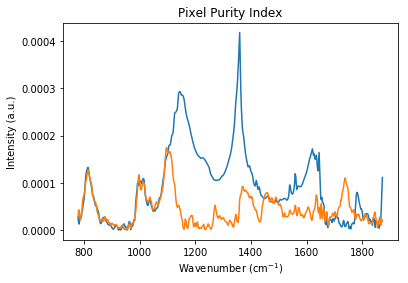

In [43]:
plt.plot(exp_wavenumber[1:550], ppi_endmembers[0,:])
plt.plot(exp_wavenumber[1:550], ppi_endmembers[1,:])
#plt.plot(exp_wavenumber[1:], ppi_endmembers[3,:])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('Pixel Purity Index')

In [44]:
#np.savetxt('PP1comp1.txt', ppi_endmembers[0])
#np.savetxt('PP1comp2.txt', ppi_endmembers[1])

In [45]:
### code written by Adrien Lagrange: https://github.com/Laadr/VCA
import sys
import scipy as sp
import scipy.linalg as splin
def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)
  
  P_y     = sp.sum(Y**2)/float(N)
  P_x     = sp.sum(x**2)/float(N) + sp.sum(r_m**2)
  snr_est = 10*sp.log10( (P_x - p/L*P_y)/(P_y - P_x) )

  return snr_est



def vca(Y,R,verbose = True,snr_input = 0):
# Vertex Component Analysis
#
# Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
#
# ------- Input variables -------------
#  Y - matrix with dimensions L(channels) x N(pixels)
#      each pixel is a linear mixture of R endmembers
#      signatures Y = M x s, where s = gamma x alfa
#      gamma is a illumination perturbation factor and
#      alfa are the abundance fractions of each endmember.
#  R - positive integer number of endmembers in the scene
#
# ------- Output variables -----------
# Ae     - estimated mixing matrix (endmembers signatures)
# indice - pixels that were chosen to be the most pure
# Yp     - Data matrix Y projected.   
#
# ------- Optional parameters---------
# snr_input - (float) signal to noise ratio (dB)
# v         - [True | False]
# ------------------------------------
#
# Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
# This code is a translation of a matlab code provided by 
# Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
# available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
# Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
#
# more details on:
# Jose M. P. Nascimento and Jose M. B. Dias 
# "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
# submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
# 
# 

  #############################################
  # Initializations
  #############################################
  if len(Y.shape)!=2:
    sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

  [L, N]=Y.shape   # L number of bands (channels), N number of pixels
       
  if (R<0 or R>L):  
    sys.exit('ENDMEMBER parameter must be integer between 1 and L')
        
  #############################################
  # SNR Estimates
  #############################################

  if snr_input==0:
    y_m = sp.mean(Y,axis=1,keepdims=True)
    Y_o = Y - y_m           # data with zero-mean
    Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
    x_p = sp.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

    SNR = estimate_snr(Y,y_m,x_p);
    
    if verbose:
      print("SNR estimated = {}[dB]".format(SNR))
  else:
    SNR = snr_input
    if verbose:
      print("input SNR = {}[dB]\n".format(SNR))

  SNR_th = 15 + 10*sp.log10(R)
         
  #############################################
  # Choosing Projective Projection or 
  #          projection to p-1 subspace
  #############################################

  if SNR < SNR_th:
    if verbose:
      print("... Select the projective proj.")
                
      d = R-1
      if snr_input==0: # it means that the projection is already computed
        Ud = Ud[:,:d]
      else:
        y_m = sp.mean(Y,axis=1,keepdims=True)
        Y_o = Y - y_m  # data with zero-mean 
         
        Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
        x_p =  sp.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
                
      Yp =  sp.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                
      x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
      c = sp.amax(sp.sum(x**2,axis=0))**0.5
      y = sp.vstack(( x, c*sp.ones((1,N)) ))
  else:
    if verbose:
      print("... Select proj. to R-1")
             
    d = R
    Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                
    x_p = sp.dot(Ud.T,Y)
    Yp =  sp.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                
    x =  sp.dot(Ud.T,Y)
    u = sp.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
    y =  x / sum( x * u)

 
  #############################################
  # VCA algorithm
  #############################################

  indice = sp.zeros((R),dtype=int)
  A = sp.zeros((R,R))
  A[-1,0] = 1

  for i in range(R):
    w = sp.random.rand(R,1);   
    f = w - sp.dot(A,sp.dot(splin.pinv(A),w))
    f = f / sp.sqrt(sum(f**2))
      
    v = sp.dot(f.T,y)

    indice[i] = sp.argmax(sp.absolute(v))
    A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

  Ae = Yp[:,indice]

  return Ae,indice,Yp


In [46]:
specmat=np.matrix.transpose(spectralfeat[1:550])
ae3, indice, yp=vca(specmat, R=2)

SNR estimated = 50.79482687054953[dB]
... Select proj. to R-1


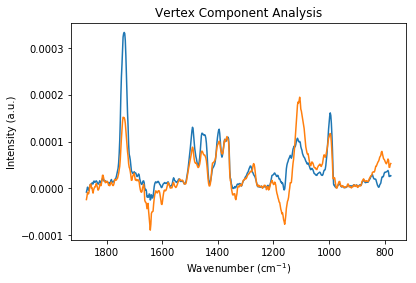

In [47]:
plt.plot(exp_wavenumber[1:550],ae3[1:550,0])
plt.plot(exp_wavenumber[1:550],ae3[1:550,1])
#plt.plot(exp_wavenumber[1:],ae3[1:,2])
#plt.plot(exp_wavenumber[1:],ae3[1:,3])
#plt.plot(exp_wavenumber[1:],ae3[1:,4])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('Vertex Component Analysis')
plt.gca().invert_xaxis()

In [48]:
#np.savetxt('VCAcomp1.txt', ae3[:,0])
#np.savetxt('VCAcomp2.txt', ae3[:,1])

## Fig S2: Raw, flattened topographies

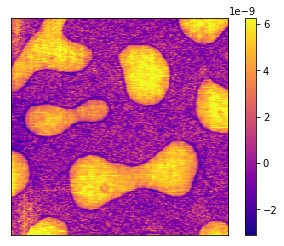

In [49]:
flattened=load_ibw('./../data/ct0_hpt1_hpi2.ibw')
cafmtopo=np.rot90(flattened[:,:,7], k=3)
show(cafmtopo)
#plt.savefig('currenttopo_RAW.svg',format='svg', dpi=350)

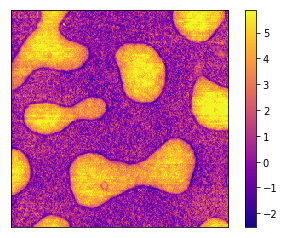

In [50]:
hypertopo=np.rot90(flattened[:,:,8], k=3)
fig=show(hypertopo)
#plt.savefig('hypertopo_RAW.svg', format='svg', dpi=350)

## Fig S4: Hyperspctral Image and Point Spectra

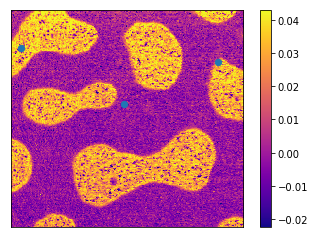

In [51]:
hypertopo=np.rot90(flattened[:,:,9], k=3)
show(hypertopo[25:,2:249], cmap='plasma')
xs = [10, 120, 220]
ys = [40, 100, 55]
plt.scatter(xs, ys, marker = 'o', s=40, cmap = "Greys")
#plt.savefig('hyperint_selectspectra.svg', format='svg', dpi=350)

In [52]:
#np.savetxt('pt1.txt', hyper_corr[10, 40, 1:550])
#np.savetxt('pt2.txt', hyper_corr[120, 100, 1:550])
#np.savetxt('pt3.txt', hyper_corr[220, 55, 1:550])
#np.savetxt('wavenumberpt.txt', exp_wavenumber[1:550])

## FIg S6: Applying the model to a different data set

In [53]:
hyperimage2 = HyperImage('./hyperspectral_pifm/Film15_0010.txt')
hyper2 = hyperimage2.hyper_image
hypertopo2 = signal.detrend(hyperimage2.channel_data[:,:,0], axis=1, type="linear")
hyperint2=signal.detrend(hyperslice(hyperimage2, start=760, stop=1875), axis=1, type="linear")
#import corresponding cAFM image 
cAFMimage2 = load_ibw('./../data/Film15cAFM_1V_0001.ibw')
cAFMtopo2 = signal.detrend(cAFMimage2[:,:,0], axis=1, type="linear")
cAFMtopo2 = rotate(cAFMtopo2, angle = 90)
cAFM2 = rotate(cAFMimage2[:,:,3], angle = 90)
cAFMlist2 = cAFM2.reshape((65536,))

#align
#optimize transformation in x-,y-space:
transform = TranslationTransform2D()
params0 = None
static = hypertopo2
moving = cAFMtopo2
cAFMrotated2=cAFM2
translation = affreg.optimize(static, moving, transform, params0, starting_affine=None)
transformed = translation.transform(moving)
#apply transformation to current image:
cAFM_transformed2 = translation.transform(cAFMrotated2)
static = hypertopo2
moving = cAFMtopo2
#use prior x-,y-transformation as starting point and optimize with respect to rotation: 
starting_affine = translation.affine
transform = RigidTransform2D() 
rigid = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply transformation to c-AFM topography: 
transformed = rigid.transform(moving)
#apply transformation to current image: 
cAFM_transformed2 = rigid.transform(cAFMrotated2)

#use prior rigid transformation as starting point and optimize with respect to a full affine transformation: 
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply to c-AFM topography
transformed = affine.transform(moving)
#apply to current image: 
cAFM_transformed2 = affine.transform(cAFMrotated2)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [54]:
spectralfeat_2 = to_2d(hyper2[25:, 0:240,:], laserpower_interp[:])

In [55]:
spectralfeat_std_2 = scale(spectralfeat_2, axis=0)
scores_2 = PCA.transform(spectralfeat_std_2[:,1:550])
cAFMshiftlist_2 = cAFM_transformed2[25:, 0:240].reshape((55440,1))

Text(0.5,1,'Predicted Current')

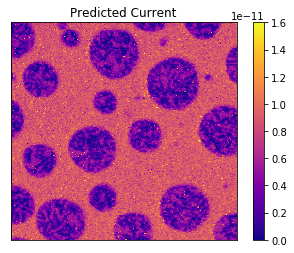

In [56]:
cAFMpred_2 = regr.predict(scores_2[:,0:PC])
cAFMpredimage_2 = cAFMpred_2.reshape((231,240))
error = cAFMpred_2-cAFMshiftlist_2
show(cAFMpredimage_2, cmap='plasma')
plt.clim(0,1.6e-11)
plt.title('Predicted Current')
#plt.savefig('predictedcurrent2.svg', format='svg', dpi=350)

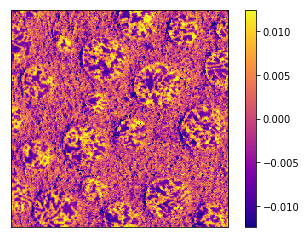

In [57]:
show(hyperint2)
#plt.savefig('hyperint2.svg', format='svg', dpi=350)

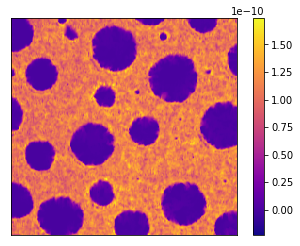

In [58]:
show(cAFM_transformed2[25:, 0:240])
#plt.savefig('cafm2.svg', format='svg', dpi=350)

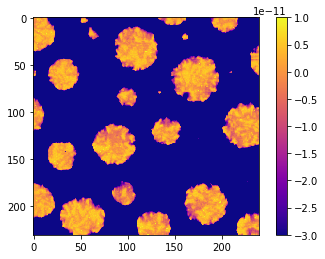

In [59]:
plt.imshow(error.reshape((231,240)), cmap='plasma')
plt.clim(-.3e-10,0.1e-10)
plt.colorbar()
#plt.savefig('cafmpred2error.svg', format='svg', dpi=350)

In [60]:
#calculate error metrics
x = cAFMshiftlist_2
y = cAFMpred_2
test_size=int(x.shape[0])
RSS = sum(np.square(error))
RSE = np.sqrt(RSS/(test_size-2))
print(RSE)

[8.33445178e-11]


## Fig S7: Training and Test masks

In [61]:
test_mask=np.zeros((231,247))
train_mask=np.zeros((231,247))
for x in range(int(test_mask.shape[0])):
    for y in range((test_mask.shape[1])):
        if int(cAFM_transformed[x+25,y+2] in test_y) == 1:
            test_mask[x,y]=1
            train_mask[x,y]=0
        else: 
            test_mask[x,y]=0
            train_mask[x,y]=1

In [62]:
train_mask=np.zeros((231,247))
for x in range(int(test_mask.shape[0])):
    for y in range((test_mask.shape[1])):
        if int(cAFM_transformed[x+25,y+2] in train_y) == 1:
            train_mask[x,y]=1
        else: 
            train_mask[x,y]=0

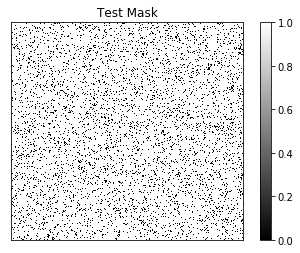

In [63]:
fig=plt.imshow(test_mask, cmap='gist_gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Test Mask')
#plt.savefig('test_mask.svg', format='svg', dpi=350)
plt.colorbar()

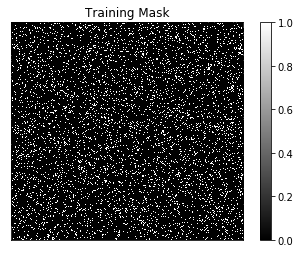

In [64]:
fig=plt.imshow(train_mask, cmap='gist_gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Training Mask')
plt.colorbar()
#plt.savefig('train_mask.svg', format='svg', dpi=350)

## Fig S8: P3HT and PMMA masks

Text(0.5,1,'P3HT mask, predicted current > 10pA')

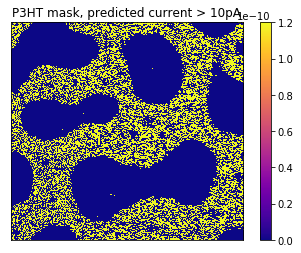

In [65]:
fig=plt.imshow(p3htmatrix_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,1.2e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('P3HT mask, predicted current > 10pA')
#plt.savefig('p3htmatrix_mask.svg', format='svg', dpi=800)

Text(0.5,1,'PMMA mask, predicted current < 2pA')

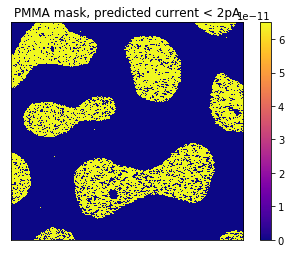

In [66]:
fig=plt.imshow(pmma_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,6.5e-11)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('PMMA mask, predicted current < 2pA')
#plt.savefig('pmma_mask.svg', format='svg', dpi=800)

## Fig S9

Text(0.5,1,'Integrated Hyperspectral at 823 cm-1')

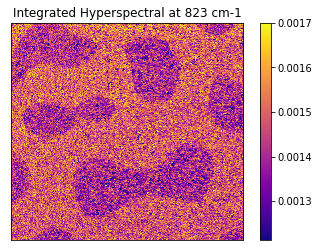

In [67]:
hypint823=hyperslice(hyperimage, start=819, stop=825)
fig=show(hypint823[25:,2:249])
plt.title('Integrated Hyperspectral at 823 cm-1')
#plt.savefig('hypint823.svg', format='svg', dpi=350)

## Fig S10

Text(0.5,1,'Pixels with measured current <2 pA')

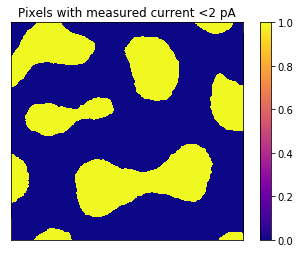

In [68]:
#selecting for pixels with measured current <2 pA, ie PMMA 
lowcurrent=np.zeros((231,247))
thresh_curr=2.0e-12
for x in range(int(lowcurrent.shape[0])):
    for y in range(int((lowcurrent.shape[1]))):
        if cAFM_transformed[x+25,y+2] < thresh_curr:
            lowcurrent[x,y]=1
        else:
            lowcurrent[x,y]=0
fig=plt.imshow(lowcurrent, cmap='plasma')
plt.clim(0,1)
plt.colorbar()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Pixels with measured current <2 pA')
#plt.savefig('lowcurrent.svg', format='svg', dpi=350)

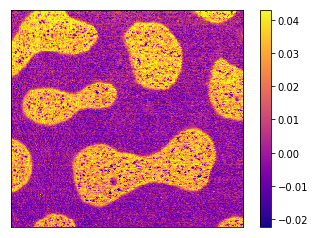

In [69]:
hyperint=np.rot90(flattened[:,:,9], k=3)
show(hyperint[25:,2:249])
#plt.savefig('hyperint.svg', format='svg', dpi=800)

Text(0.5,1,'Pixels with integrated hyperspectral intensity <0')

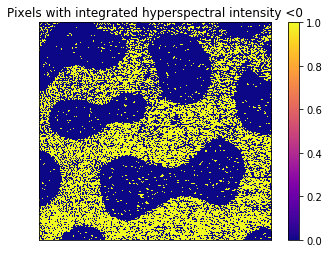

In [70]:
#selecting for pixels with integrated hyperspectral intensity <0.00, ie P3HT
lowhyper=np.zeros((231,247))
thresh_intensity=0
for x in range(int(lowhyper.shape[0])):
    for y in range(int((lowhyper.shape[1]))):
        if hyperint[x+25, y+2] < thresh_intensity:
            lowhyper[x,y]=1
        else:
            lowhyper[x,y]=0
fig=plt.imshow(lowhyper, cmap='plasma')
plt.clim(0,1)
plt.colorbar()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Pixels with integrated hyperspectral intensity <0')
#plt.savefig('lowhyper.svg', format='svg', dpi=350)

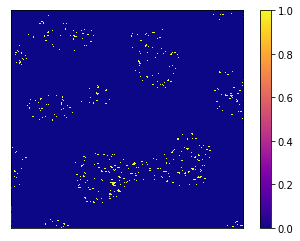

In [71]:
#combining the two conditions above: 
lowcurrentlowhyper=np.zeros((231,247))
for x in range(int(lowcurrentlowhyper.shape[0])):
    for y in range(int((lowcurrentlowhyper.shape[1]))):
        if cAFM_transformed[x+25,y+2] < thresh_curr and hyperint[x+25, y+2] < thresh_intensity:
            lowcurrentlowhyper[x,y]=1
        else:
            lowcurrentlowhyper[x,y]=0
fig=plt.imshow(lowcurrentlowhyper, cmap='plasma')
plt.clim(0,1)
plt.colorbar()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#plt.savefig('lowhyperlowcurrent.svg', format='svg', dpi=350)